
1. Сгенерировать данные.  
2. Построить модель логистической регрессии и оценить среднюю точность.  
3. Использовать статистические методы для отбора признаков:  
    a. Выбрать признаки на основе матрицы корреляции.  
    b. Отсчь низковариативные признаки `(VarianceThreshold)`.  
    c. Повторить п. 2 на отобранных признаках в п. 3a, п. 3b.  
4. Осуществить отбор признаков на основе дисперсионного анализа:  
5. Отбор с использованием моделей:  
    a. Реализовать отбор признаков с помощью логистической регрессии. Отобранные признаки подайть далее на вход в саму логистическую регрессию `(SelectFromModel)`. Используйте L1 регуляризацию.  
    b. Реализовать отбор признаков с помощью модели `RandomForest` и встроенного атрибута `feature_impotance`.  
    c. Повторить п. 2 на отобранных признаках в п. 5a, п. 5b.  
6. Перебор признаков:  
    a. `SequentialFeatureSelector`.  
    b. Повторить п. 2 на отобранных признаках.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import (VarianceThreshold, 
                                       SelectKBest, 
                                       SelectFromModel, 
                                       SequentialFeatureSelector,
                                       f_classif)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import shap
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

pd.options.display.float_format = '{:.3f}'.format

/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_env/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/Caskroom/miniconda/base/envs/jupyter_env/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-us

#### 1. Генерируем данные

In [2]:
x_data_generated, y_data_generated = make_classification(scale=1, random_state=1)

#### 2. Строим модель логистической регрессии

In [3]:
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring="accuracy").mean()

0.9

Перенесем логику рекомендуемого кода в отдельную функцию

In [4]:
def get_score(data, target, rs=1, title='default'):
    score = cross_val_score(
        LogisticRegression(random_state=rs), 
        data, 
        target, 
        scoring="accuracy").mean()
    metrix = {}
    metrix['score'] = score
    metrix['features_cnt'] = data.shape[1]
    res = pd.DataFrame.from_dict(metrix, orient='index', columns=[title])    
    return res

In [5]:
res = pd.DataFrame()

In [6]:
res_0 = get_score(x_data_generated, y_data_generated)
res = pd.concat([res, res_0], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
default,0.900,20.000


#### 3. Статистические методы для отбора признаков

Оценим корреляцию по матрице

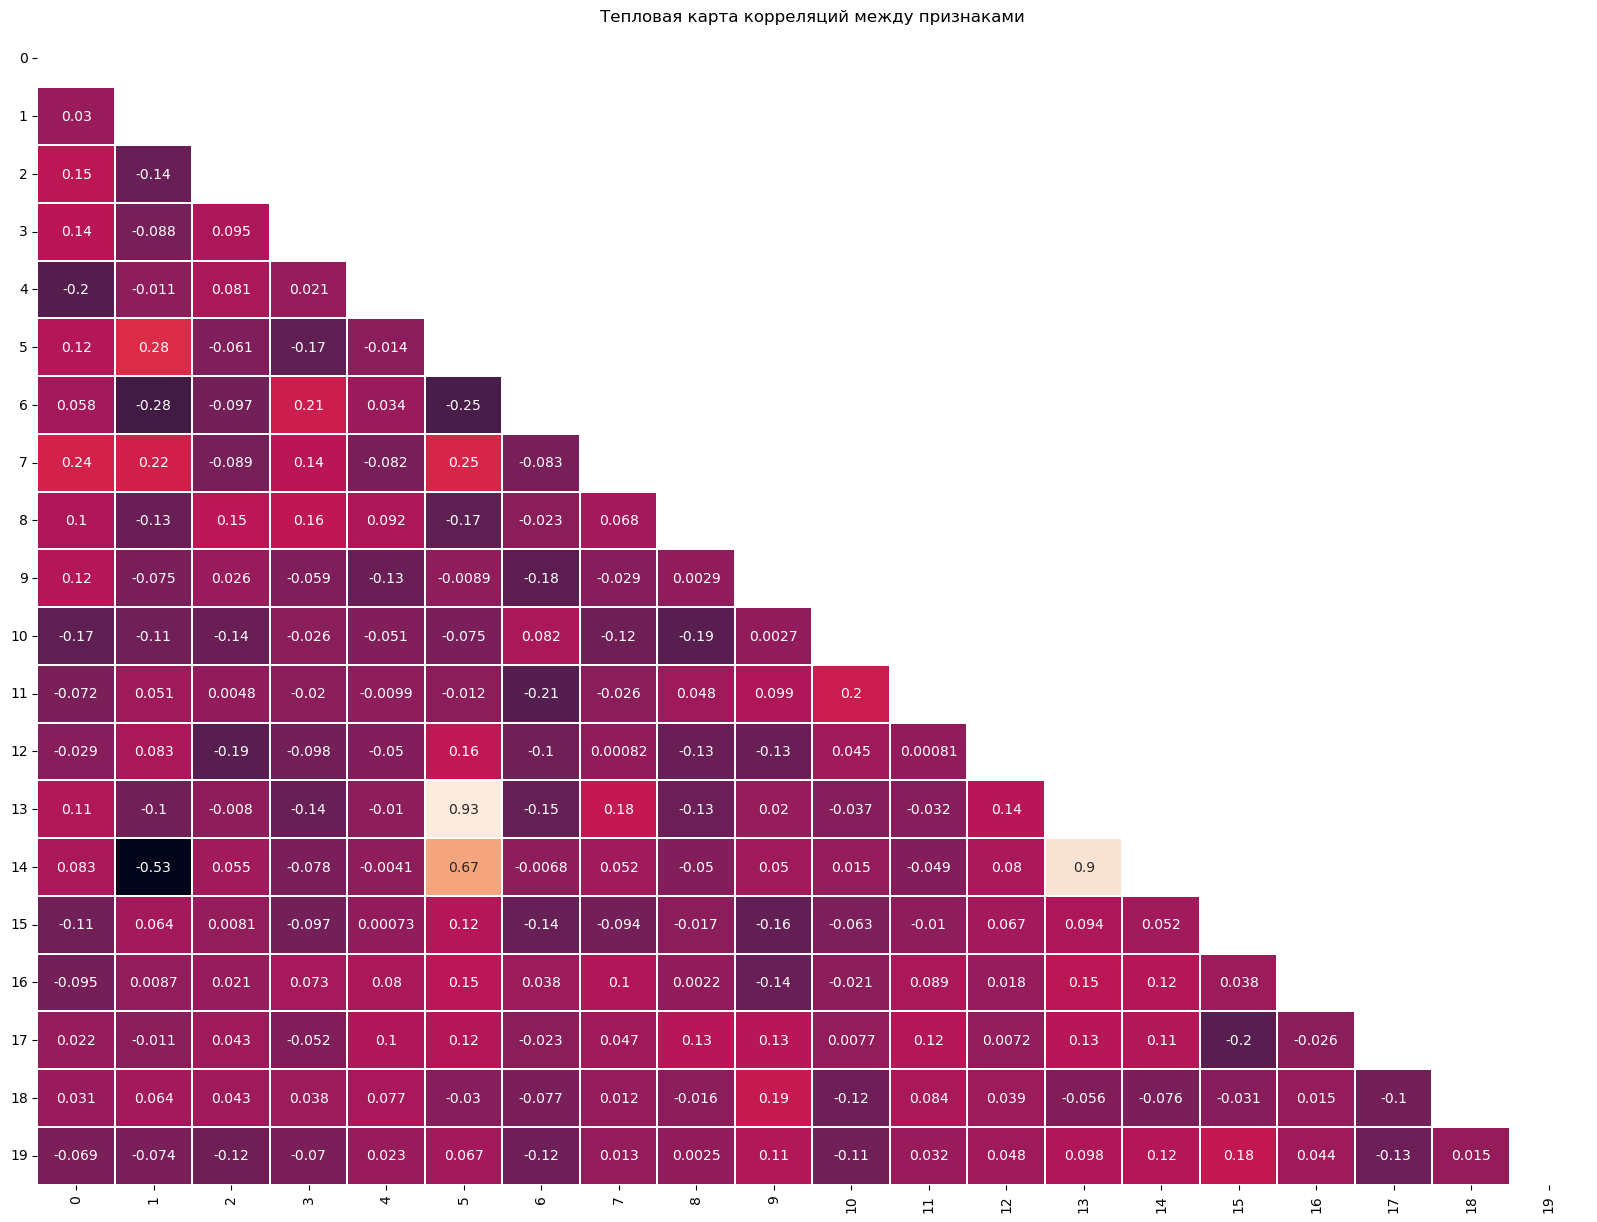

In [7]:
data = pd.DataFrame(x_data_generated)
fig = plt.figure(figsize=(20,15))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, fmt='.2g', mask=mask, linecolor = 'white', linewidths=0.3, cbar=False)
plt.title('Тепловая карта корреляций между признаками')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Высокая корреляция 
* 13-5  
* 14-5  
* 14-13  
* 14-1 
____
Удаляем 13, 5 и 1

In [8]:
data2 = data.drop(columns=[13, 5, 1]).copy()

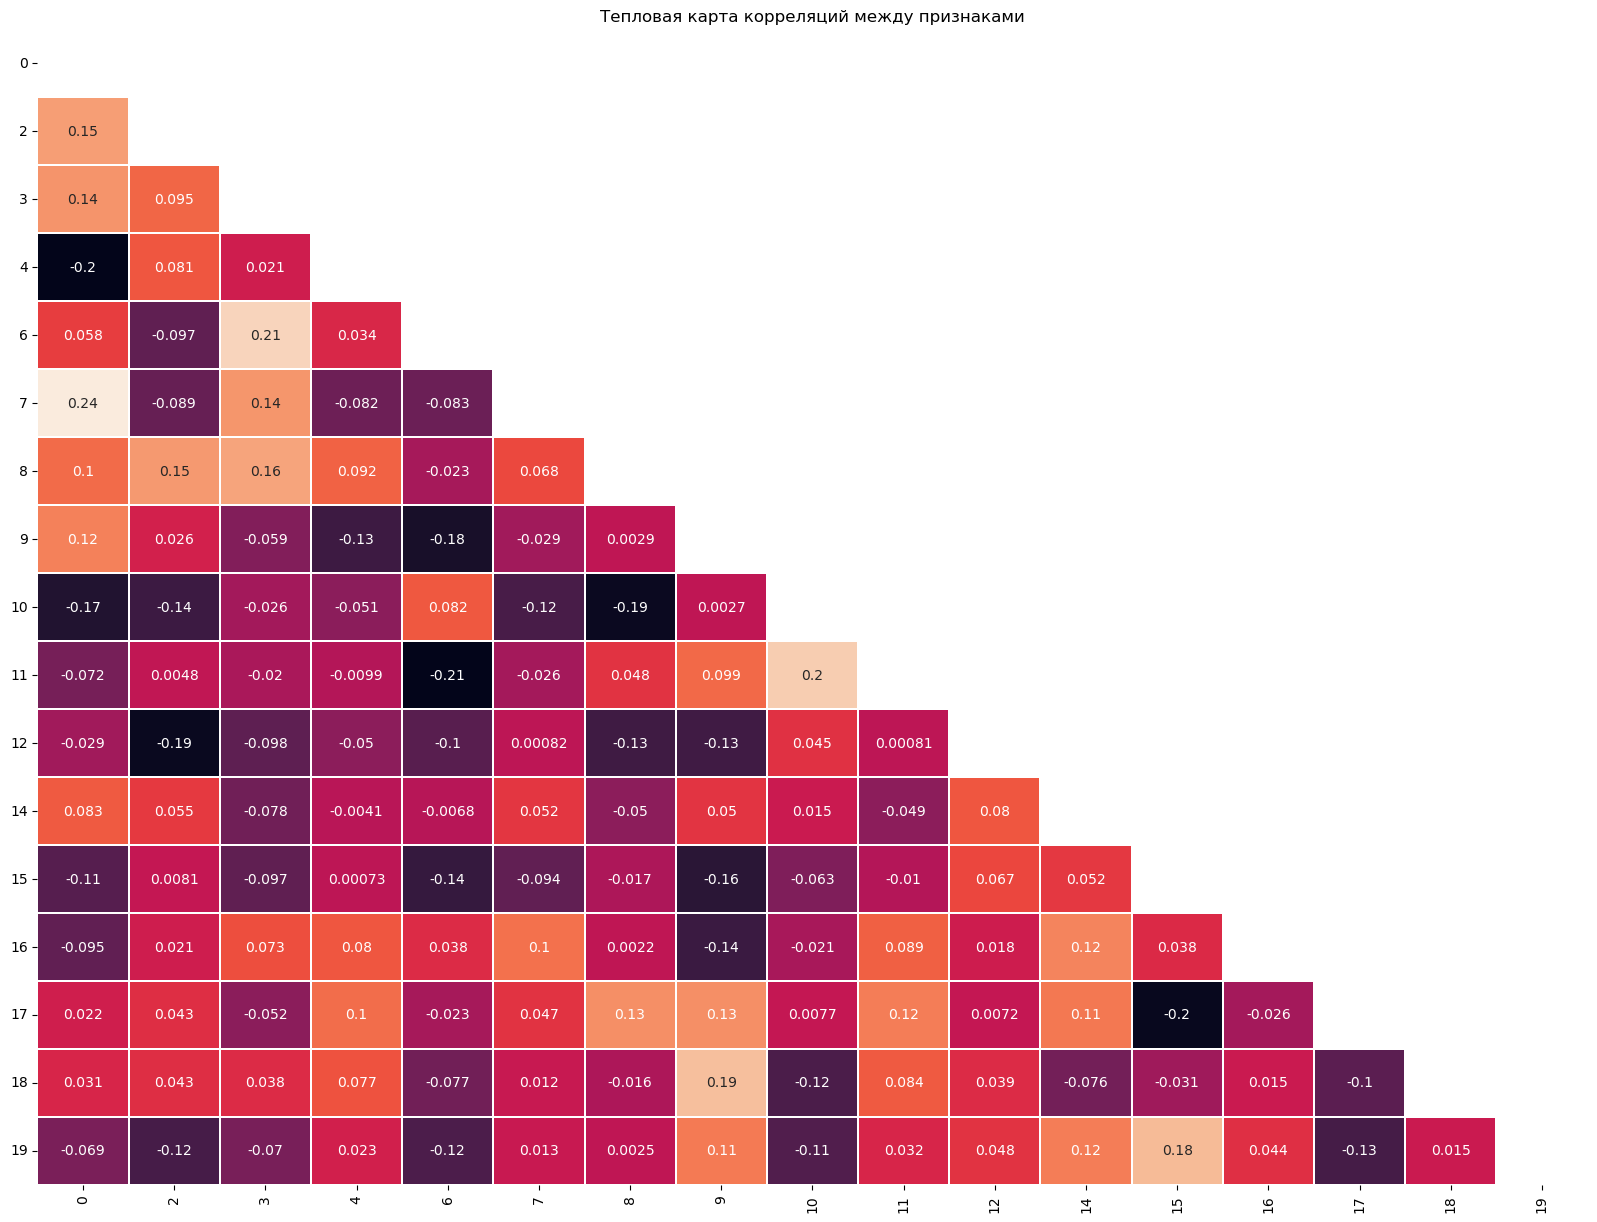

In [9]:
fig = plt.figure(figsize=(20,15))
mask = np.triu(data2.corr())
sns.heatmap(data2.corr(), annot=True, fmt='.2g', mask=mask, linecolor = 'white', linewidths=0.3, cbar=False)
plt.title('Тепловая карта корреляций между признаками')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [10]:
res_1 = get_score(data2, y_data_generated, title='удаление по матрице')
res = pd.concat([res, res_1], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
default,0.900,20.000
удаление по матрице,0.700,17.000


Очень странно, но удаление признаков с высокой корреляцией вызвало обратный эффект

Отсекаем низковариативные признаки

In [11]:
vt = VarianceThreshold(threshold=1)
vt.fit(data)
list(zip(pd.DataFrame(x_data_generated).columns, vt.get_support()))

[(0, True),
 (1, True),
 (2, True),
 (3, False),
 (4, False),
 (5, False),
 (6, False),
 (7, True),
 (8, False),
 (9, False),
 (10, True),
 (11, False),
 (12, True),
 (13, True),
 (14, True),
 (15, False),
 (16, False),
 (17, False),
 (18, True),
 (19, False)]

In [12]:
data3 = vt.transform(data)

In [13]:
data3.shape

(100, 9)

In [14]:
res_3 = get_score(data3, y_data_generated, title='VarianceThreshold')
res = pd.concat([res, res_3], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
VarianceThreshold,0.940,9.000
default,0.900,20.000
удаление по матрице,0.700,17.000


#### 4. Отбор признаков на основе дисперсионного анализа

In [15]:
data4 = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
data4.shape

(100, 5)

In [16]:
res_4 = get_score(data4, y_data_generated, title='SelectKBest')
res = pd.concat([res, res_4], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
SelectKBest,0.960,5.000
VarianceThreshold,0.940,9.000
default,0.900,20.000
удаление по матрице,0.700,17.000


#### 5. Отбор с использованием моделей

In [17]:
lsvc = LinearSVC(C = 0.12, penalty="l1", dual=False)
lsvc.fit(x_data_generated, y_data_generated)
model = SelectFromModel(lsvc, prefit=True)
data5 = model.transform(x_data_generated)
data5.shape

(100, 6)

In [18]:
res_5 = get_score(data5, y_data_generated, title='LinearSVC')
res = pd.concat([res, res_5], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
SelectKBest,0.960,5.000
LinearSVC,0.950,6.000
VarianceThreshold,0.940,9.000
default,0.900,20.000
удаление по матрице,0.700,17.000


In [19]:
model = RandomForestClassifier(
    n_estimators=20, 
    max_depth=None, 
    min_samples_split=2, 
    random_state=1, 
    max_features=6)
model.fit(x_data_generated, y_data_generated)
coeff = model.feature_importances_
sorted(
    dict(zip(pd.DataFrame(x_data_generated).columns, coeff)).items(), 
    key=lambda kv: kv[1],
    reverse=True
)

[(1, 0.4887853587302773),
 (14, 0.1703185897683508),
 (5, 0.08281002797479736),
 (7, 0.039353363812967807),
 (13, 0.03895487069288862),
 (6, 0.03404707434394057),
 (8, 0.030197828903306297),
 (11, 0.022610275853969696),
 (17, 0.01853854899615936),
 (12, 0.018002345380596987),
 (18, 0.017977867999947977),
 (16, 0.01267081951298649),
 (2, 0.006101989797641973),
 (19, 0.005586233268687049),
 (0, 0.004893995789746502),
 (10, 0.004816814868715998),
 (15, 0.0040024293182819425),
 (4, 0.0003315649867373994),
 (3, 0.0),
 (9, 0.0)]

Оставим 6 первых признаков

In [20]:
data6 = data.loc[:, [1, 14, 5, 7, 13, 6]]
res_6 = get_score(data6, y_data_generated, title='RandomForestClassifier')
res = pd.concat([res, res_6], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
SelectKBest,0.960,5.000
RandomForestClassifier,0.960,6.000
LinearSVC,0.950,6.000
VarianceThreshold,0.940,9.000
default,0.900,20.000
удаление по матрице,0.700,17.000


#### 6. Перебор признаков

Попробуем оставить всего 4 признака - __1/5__ первоначального набора

In [21]:
lr = LogisticRegression()
sfs = SequentialFeatureSelector(lr, n_features_to_select=4)
sfs.fit(x_data_generated, y_data_generated)
sfs.get_support()
list(zip(pd.DataFrame(x_data_generated).columns, sfs.get_support()))

[(0, True),
 (1, True),
 (2, False),
 (3, True),
 (4, True),
 (5, False),
 (6, False),
 (7, False),
 (8, False),
 (9, False),
 (10, False),
 (11, False),
 (12, False),
 (13, False),
 (14, False),
 (15, False),
 (16, False),
 (17, False),
 (18, False),
 (19, False)]

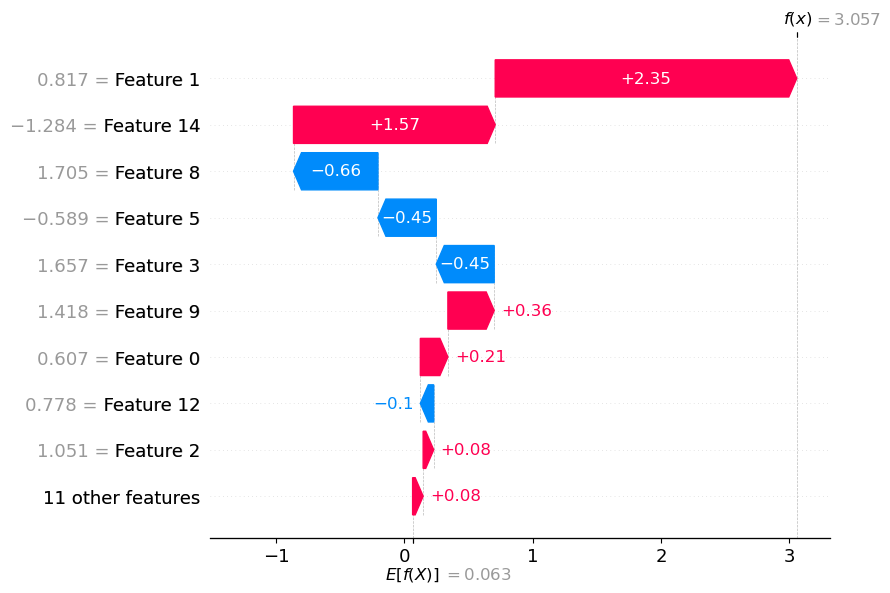

In [22]:
model = LogisticRegression().fit(x_data_generated, y_data_generated)
explainer = shap.Explainer(model, x_data_generated)
shap_values = explainer(x_data_generated)
shap.plots.waterfall(shap_values[0])

In [23]:
data8 = sfs.transform(x_data_generated)

In [24]:
res_8 = get_score(data8, y_data_generated, title='SequentialFeatureSelector')
res = pd.concat([res, res_8], axis=1)
res.T.sort_values(['score', 'features_cnt'], ascending=[False, True])

,score,features_cnt
SequentialFeatureSelector,0.960,4.000
SelectKBest,0.960,5.000
RandomForestClassifier,0.960,6.000
LinearSVC,0.950,6.000
VarianceThreshold,0.940,9.000
default,0.900,20.000
удаление по матрице,0.700,17.000


#### Вывод:  
_____

Максимум что можно выжать из модели это метрика 96%. С помощью вышеперечисленных методов мы существенно сокращаем нагрузку на вычислительные мощности не в ущерб качеству модели. Столь высокую метрику можно получить и на 4 признаках. Такие преобразования особенно полезны когда в модели сотни и тысячи признаков.  
К тому же, как в случае с метрикой после удаления признаков с высокой корреляцией, мы страхуем себя от неверного удаления столбцов. 